# Laser Sensor Outdoor Tests

## Objective

The objective of this notebook is to determine the sensor's effectiveness in detecting and measuring the distances of vehicles in a real-world setting.

## Overview

First, I mounted the sensor on a stationary bike and positioning it along a busy road to test its ability to detect passing vehicles. Next, with the same set up, the bike was cycled down different roads and the data from overtaking vehicles was collected. I wanted to first test the sensor in a more controlled setting before applying it in a more dynamic environment.

### Code

To prevent this notebook from being cluttered, I have split some of the code into separate Python modules found in the same directory.

- [`data_cleaner.py`](./data_cleaner.py) contains functions to help clean data.
- [`data_loader.py`](./data_loader.py) helps to extract the sensor data from the text files.
- [`outdoor_graphs.py`](./outdoor_graphs.py) helps to graph the data.

# Laser Sensor Outdoor Tests

## Objective

Determine the laser sensor's capability in detecting and gauging distances of vehicles in genuine outdoor settings.

## Experiment Details

### Experiment Setup

1. **Stationary Test**: The sensor was initially mounted on a stationary bike alongside a busy road to gauge its proficiency in detecting passing vehicles.
2. **Dynamic Test**: Retaining the setup, the bike was ridden by a food delivery rider, collecting data from vehicles overtaking the cyclist. This step transitioned the evaluation from a controlled setting to a more dynamic environment, offering insights into real-world applicability.

### Data Extraction

- **Raspberry Pi**: As before, data from the sensor was published over to AWS IoT's message broker via MQTT. I then extracted the data in to text files. Each line of measurement contains the time, distance, and signal strength:

    ```text
    10:45:37 1623 4
    ```

- **Default Software**: I also used the default software to collect data, where I extracted the data into text files and formatted it. Each raw measurement was formatted like so:

    ```text
    [2023-08-22 14:54:49.301 R]1947
    ```

## Technical Insights

- **Sensor Frequency**: As per the sensor's documentation, the sensor operates at a frequency of 20Hz, translating to 20 measurements every second. However in rpactice, this was variable and the frequency sometimes averaged less than 10Hz.

## Code Setup

### Imports

To maintain a clean and organized notebook, various functionalities have been distributed into separate Python modules:

- [`cleaner.py`](../src/data/cleaner.py) includes data cleaning functions.
- [`loader.py`](../src/data/loader.py) aids in extracting sensor data from text files.
- [`outdoor_graphs.py`](../src/graphing/outdoor_graphs.py) provides utilities for data visualization.

In [1]:
import datetime
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline

sys.path.append("../src")

from data import cleaner, loader
from graphing import outdoor_graphs

### Data Preparation and Loading

I load the data for the stationary tests and food delivery ride. I also define a helper function to extract data from files in a consistent format.

In [2]:
STATIONARY_PATH_1 = pathlib.Path("../data/processed/laser_outdoor_tests/yuan_ching_rd.txt")
STATIONARY_PATH_2 = pathlib.Path("../data/processed/laser_outdoor_tests/yuan_ching_rd_2.txt")
FOOD_DELIVERY_1 = pathlib.Path("../data/processed/laser_outdoor_tests/food_delivery_1.txt")


def extract_data_from_file(file_path: pathlib.Path) -> tuple[list]:
    """
    Helper function that extracts data from file.

    Args:
        file_path (pathlib.Path): Data file.

    Returns:
        tuple[list]: Returns timings, distances, and signal strengths.
    """
    timings, distances, strengths = loader.load_data_from_file(file_path)
    distances = cleaner.fliter_above(distances, 3500)
    return timings, distances, strengths

## Stationary Test

In the first test, the sensor was mounted on a stationary bike along Yuan Ching Rd. which saw moderate traffic. I also mounted a Go Pro to capture a video of the vehicles that passed the bike. I cross referenced the data collected from the sensor and the Go Pro's video feed to determine the reliability of the sensor.

### Laser Sensor with Raspberry Pi

The sensor exhibited enhanced precision and accuracy, with minimal erroneous data. Nonetheless, despite a 20Hz advertised frequency, actual readings were inconsistent and lower, impacting its capacity to detect all passing vehicles.

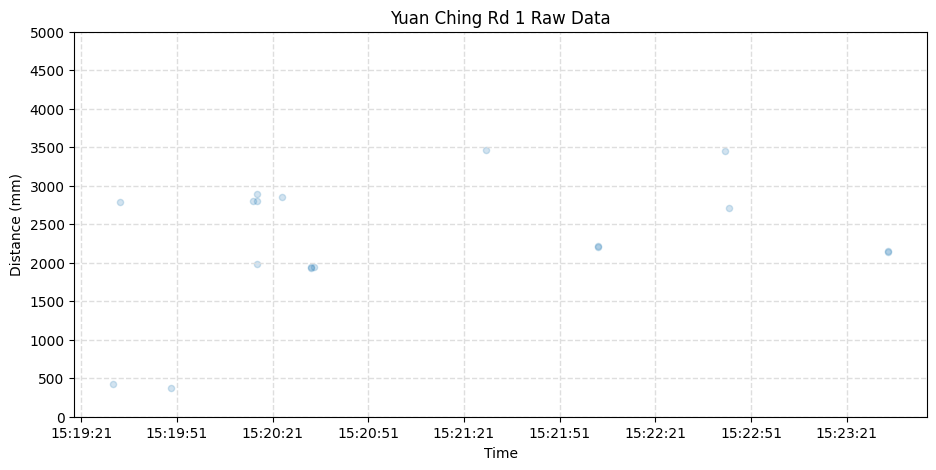

In [3]:
timings, distances, strengths = extract_data_from_file(STATIONARY_PATH_1)

fig, axes = plt.subplots(figsize=(11, 5))
outdoor_graphs.scatter_time_vs_distance(axes, timings, distances, "Yuan Ching Rd 1 Raw Data")
plt.show()

### Laser Sensor with Windows Software

The proprietary software enabled the sensor to operate consistently at 20Hz. This change manifested in the increased data points captured, signifying the sensor's dependability.

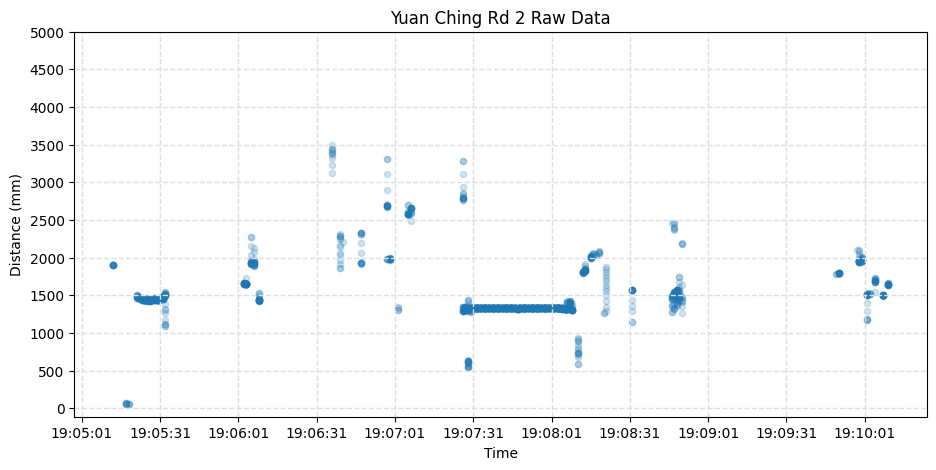

In [4]:
timings, distances, strengths = extract_data_from_file(STATIONARY_PATH_2)

fig, axes = plt.subplots(figsize=(11, 5))
outdoor_graphs.scatter_time_vs_distance(axes, timings, distances, "Yuan Ching Rd 2 Raw Data")
plt.show()

### Data Cleaning Algorithm

To better determine the average distances of cars that pass the sensor, I replaced the value of all points in each respective cluster, with the average distance of the cluster, making clusters more easily identifiable.

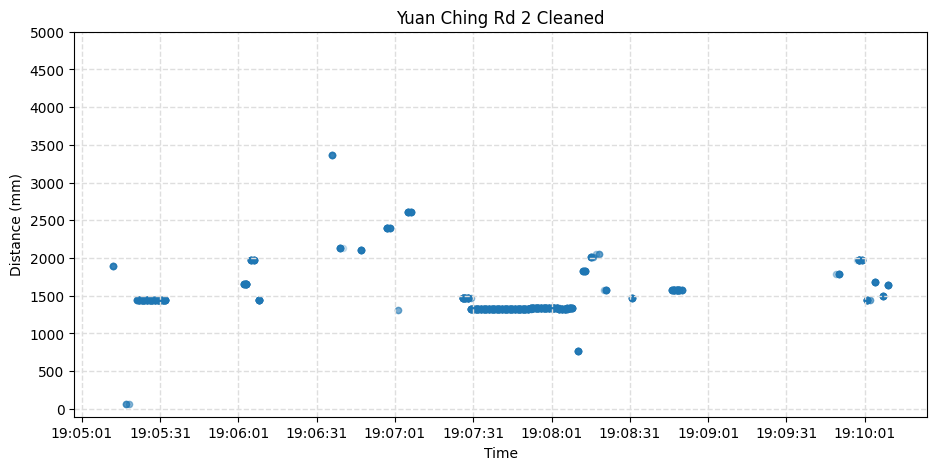

In [5]:
fig, axes = plt.subplots(figsize=(11, 5))
cleaned_distances = cleaner.average_clusters(distances)
outdoor_graphs.scatter_time_vs_distance(axes, timings, cleaned_distances, "Yuan Ching Rd 2 Cleaned")
plt.show()

### Data Cross-Reference with Video Feed

- **General Observations**:
  - The cleaned data accurately and reliably pinpointed the clusters representing passing vehicles.
  - Around 19:06:40, the vehicles in the video are moving very quickly, and the sensor appears to have missed out on 5 of these vehicles.
  - While the sensor may miss some fast moving vehicles, the vehicles it detects remain accurate.
- **Vehicle Type Analysis**:
  - The sensor performs best at detecting slow or stationary vehicles, as seen by the dark line in the center that represents the stationary bus.
  - The 3 dark clusters of points just after 19:06:01 where 3 slow moving vehicles passed the sensor.

![Yuan Ching Rd](../assets/annotated_graphs/Yuan_Ching_rd.png)

## On-Road Cycling Tests

For this experiment, I mounted the sensor on a bike which a food delivery rider used to cycle along traffic. Food delivery riders frequently cycle on Singapore roads to delivery food through food delivery apps like Grab or Food Panda. As such, the data collected reflect the real-world conditions of cycling on Singapore roads.

### Food Delivery Ride Analysis

- **Setup and Initial Observations**:
  - The food delivery rider cycled a 5-6km loop on public roads exposed to traffic in the Jurong West area.
  - At a galnce it can be seen that the large majority of data points fall below the 1.5m mark, suggesting that many vehicles overtook the cyclist too close.
- **Data Cleaning**:
  - I employed the previous cleaning algorithm to clean the clusters in the second graph.

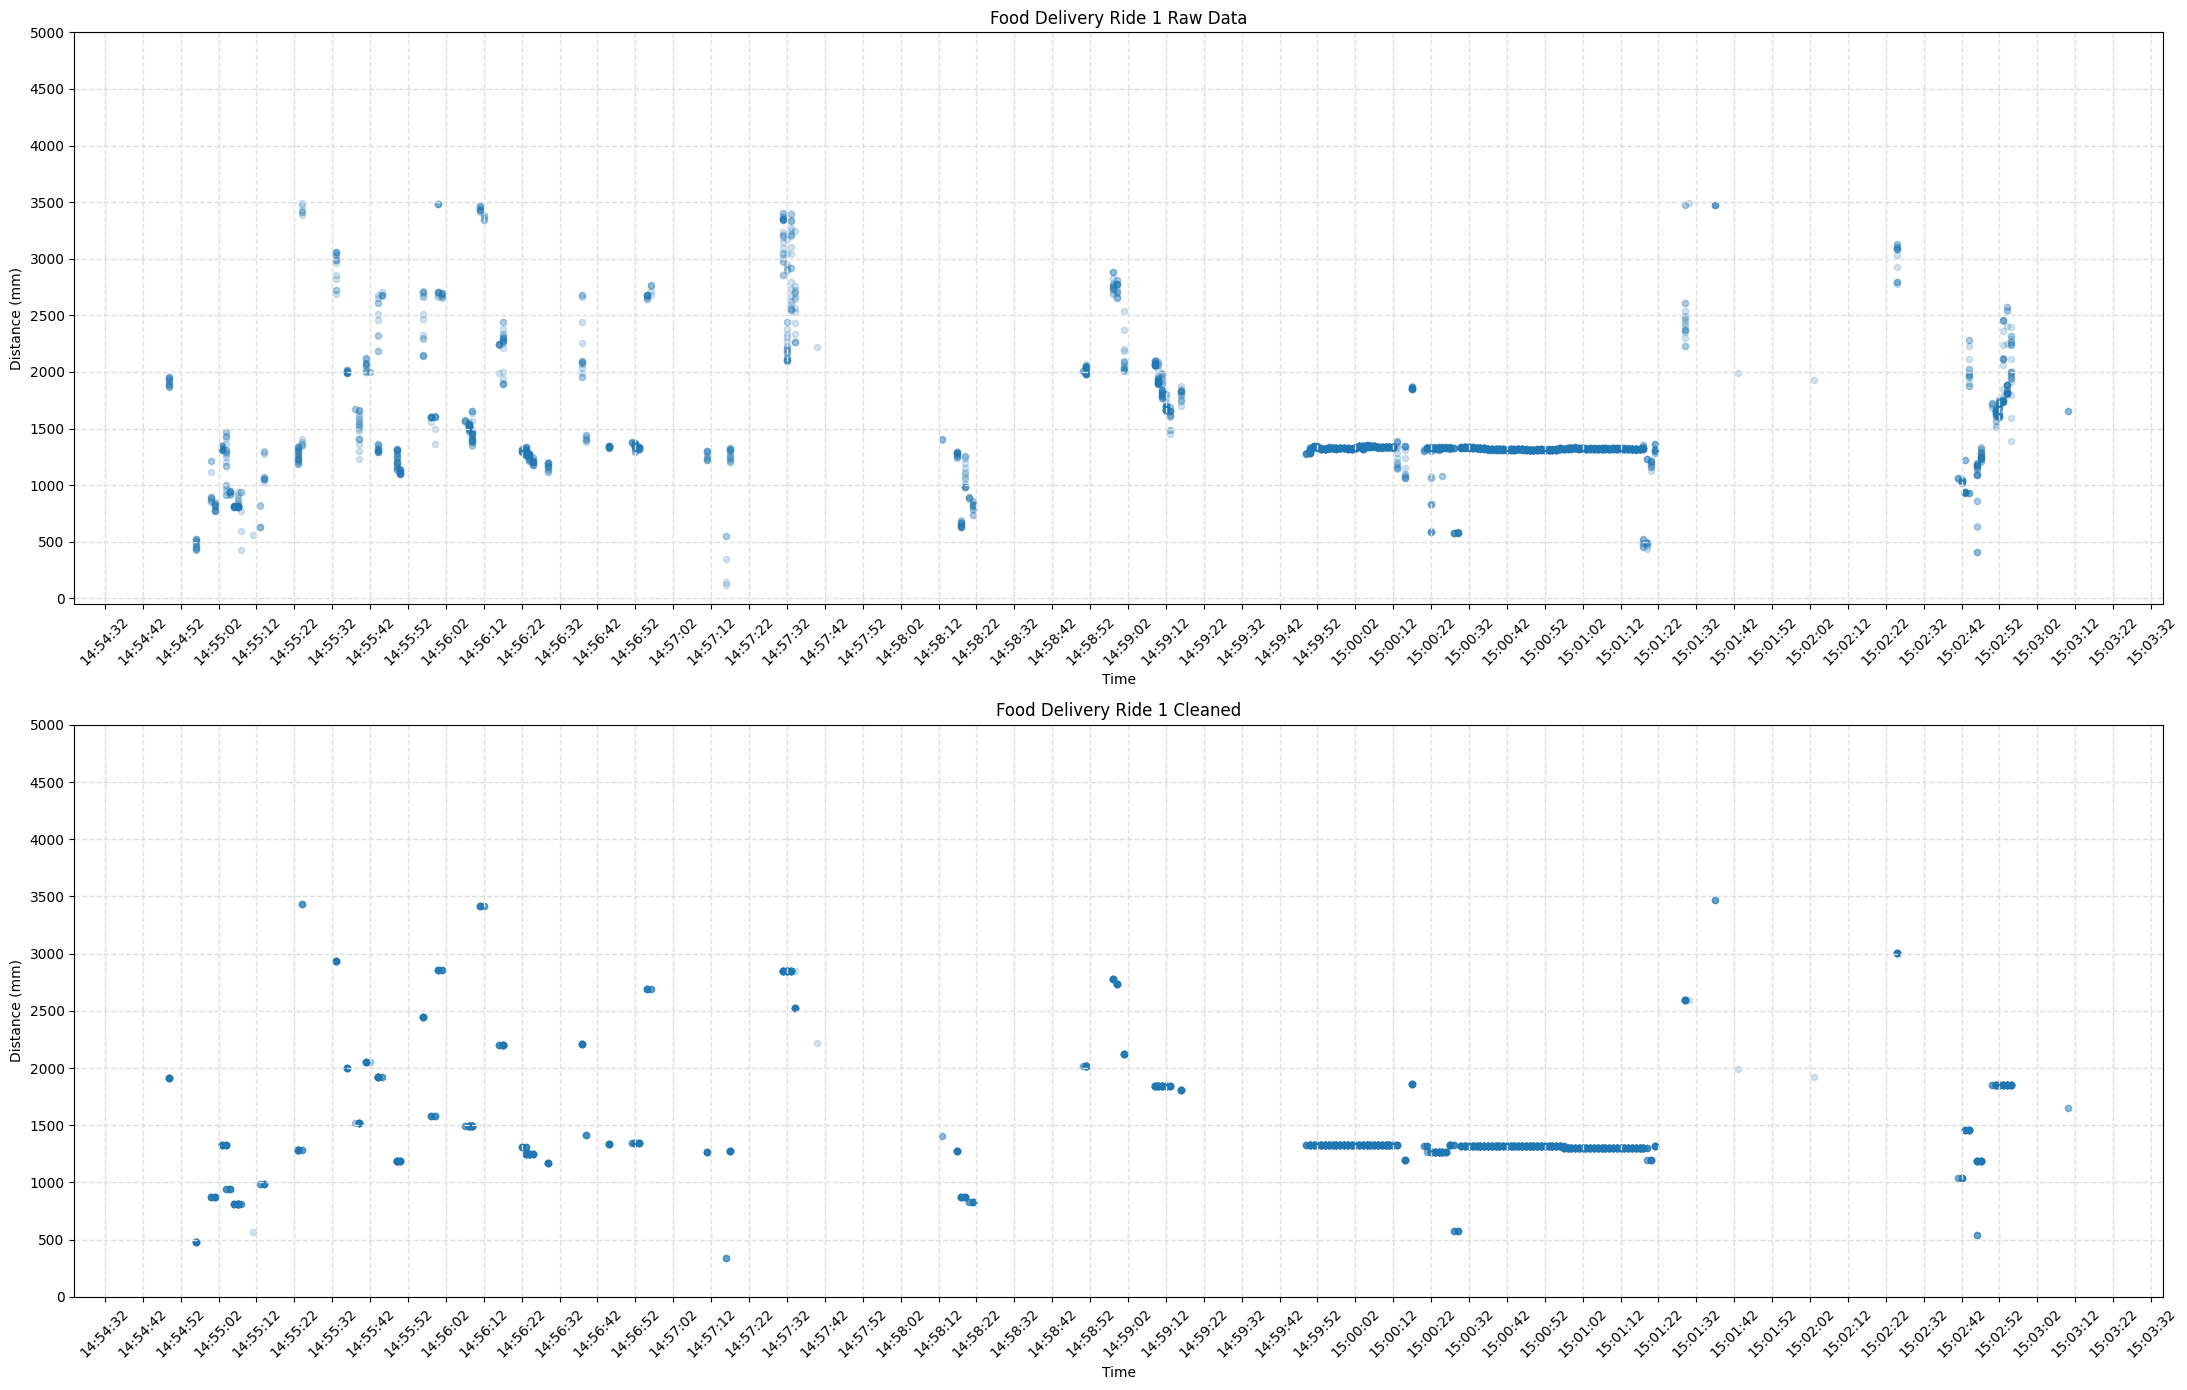

In [6]:
timings, distances, strengths = extract_data_from_file(FOOD_DELIVERY_1)
cleaned_distances = cleaner.average_clusters(distances)

fig, axes = plt.subplots(2, 1, figsize=(22, 14))
outdoor_graphs.scatter_time_vs_distance(axes[0], timings, distances, "Food Delivery Ride 1 Raw Data", 10, True)
outdoor_graphs.scatter_time_vs_distance(axes[1], timings, cleaned_distances, "Food Delivery Ride 1 Cleaned", 10, True)
plt.tight_layout()
plt.show()

- **Legend**:
  - Red Circles: Vehicles overtaking the cyclist.
  - Blue Circles: Stopped vehicles that the cyclist moves past.
  - Black Circles: Non-vehicles.
  - Black Rectangle: Vehicles in the same lane as the cyclist.
- **Video-Assisted Analysis**:
  - The most valuable data falls between 14:55:22 and 14:56:32 which likely reflects the average road conditions that cyclists experience with regard to being overtaken by vehicles.
  - **Of the 6 vehicles that overtook the cyclist in the same lane, 3 passed at 1.5m while the other 3 passed at less than 1.5m. In fact, the bus at 14:55:50 passed at the closest distance at around 1.2m.**

![Food Delivery Ride 1 Cleaned](../assets/annotated_graphs/Food%20Delivery%20Ride%201%20Cleaned.png)

### Interactive Visualization

An interactive scatter plot was created, allowing users to view overtaking vehicle images by clicking on data points. This feature necessitated manual data extraction to associate each scatter point with its corresponding image. I've included an image as this interactive feature can only be used when running the notebook.

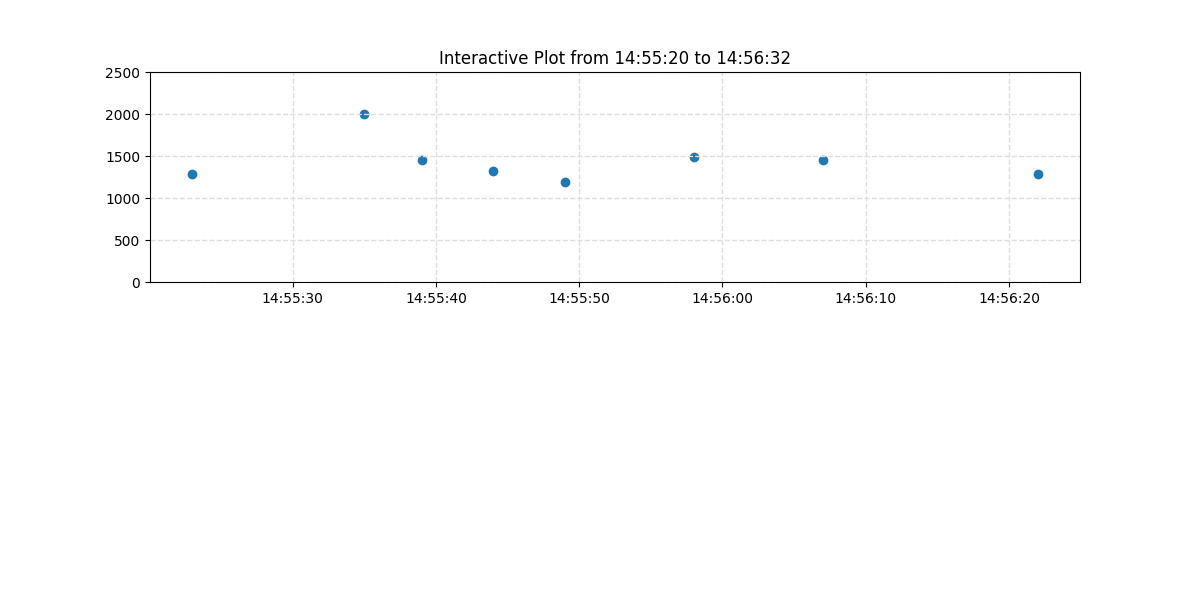

In [7]:
%matplotlib widget

images = pathlib.Path("../assets/screenshots/food_delivery_ride_1/")
distances = [1284, 2000, 1456, 1318, 1190, 1491, 1454, 1283]
timings = [datetime.datetime(1900, 1, 1, 14, 55, 23), datetime.datetime(1900, 1, 1, 14, 55, 35), datetime.datetime(1900, 1, 1, 14, 55, 39), datetime.datetime(1900, 1, 1, 14, 55, 44), datetime.datetime(1900, 1, 1, 14, 55, 49), datetime.datetime(1900, 1, 1, 14, 55, 58), datetime.datetime(1900, 1, 1, 14, 56, 7), datetime.datetime(1900, 1, 1, 14, 56, 22)]


def on_pick(event):
    """
    Callback function that shows image when clicking on scatter point.

    Args:
        event (_type_): Matplotlib's click event object.
    """
    axes[1].clear()
    axes[1].axis("off")
    i = event.ind[0]
    img = np.asarray(Image.open(list(images.iterdir())[i]))
    axes[1].imshow(img)
    axes[1].text(
        0.5,
        0.5,
        f"Passing Distance: {distances[i] / 1000:.2f}m",
        color="white",
        fontsize=12,
        ha="center",
        va="center",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="black", edgecolor="white", alpha=0.6
        ),
    )
    plt.draw()


fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].scatter(timings, distances, picker=True)
axes[0].set_title("Interactive Plot from 14:55:20 to 14:56:32")
axes[0].set_yticks(range(0, 3000, 500))
axes[0].grid(color="#DEDEDE", linestyle="--", linewidth=1)
axes[1].axis("off")

fig.canvas.mpl_connect("pick_event", on_pick)
plt.show()

![Interactive Scatter Plot](../assets/screenshots/Interactive_Graph.png)

## Conclusion

After testing and analysis in various settings, my investigation of the laser sensor's capabilities yields several crucial findings:

1. **Raw Data Observations**: While reliable at detecting vehicles, using the laser sensor's frequency proved a challenge in consistently detecting fast moving vehicles when used with the Raspberry Pi.
2. **Data Cleaning Efficacy**: The cleaning algorithm did not make significant improvements to the data, only providing a better visualization by making clusters more obvious.
3. **Sensor Reliability**: The laser sensor was effective in detecting vehicles when used with the proprietary software that increased its frequency. 
4. **Real-World Application**: The sensor was effective at detecting vehicles in real-world conditions, as shown from the data collected - I was able to show that vehicles on Singapore roads do not abide by the 1.5m overtaking distance.

The laser sensor succeeded in collecting data to demonstrate the overtaking distance of vehicles in real-world conditions. But the data from the sensor was only reliable when supplemented with the video recording from the Go Pro. To fully automate this process, I would need to use a camera with vehicle detection capabilities, to ensure the object being measured by the laser is indeed a vehicle and not some other stationary object.